In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import random
import tensorflow.keras.utils as utils
import pydot
from tensorflow.keras import regularizers

In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_gpu_available()
!python --version

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5451726513951875591
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13708208447931657705
physical_device_desc: "device: XLA_CPU device"
]
2.3.1
Num GPUs Available:  0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
/bin/bash: python: command not found


In [3]:
dataset_dir = "./Datasets/energydata_complete.csv"

In [4]:
df = pd.read_csv(dataset_dir, index_col=None)
df = df.fillna(df.mean())
df.head(10)

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.20,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.500000,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.20,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.600000,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.20,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.700000,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.20,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.800000,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.20,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.900000,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
5,2016-01-11 17:50:00,50,40,19.890000,46.026667,19.20,44.500000,19.79,44.933333,18.890000,...,17.000000,45.29,6.016667,734.000000,92.000000,5.333333,43.833333,4.800000,44.919484,44.919484
6,2016-01-11 18:00:00,60,50,19.890000,45.766667,19.20,44.500000,19.79,44.900000,18.890000,...,17.000000,45.29,5.900000,734.100000,92.000000,5.000000,40.000000,4.700000,47.233763,47.233763
7,2016-01-11 18:10:00,60,50,19.856667,45.560000,19.20,44.500000,19.73,44.900000,18.890000,...,17.000000,45.29,5.916667,734.166667,91.833333,5.166667,40.000000,4.683333,33.039890,33.039890
8,2016-01-11 18:20:00,60,40,19.790000,45.597500,19.20,44.433333,19.73,44.790000,18.890000,...,17.000000,45.29,5.933333,734.233333,91.666667,5.333333,40.000000,4.666667,31.455702,31.455702
9,2016-01-11 18:30:00,70,40,19.856667,46.090000,19.23,44.400000,19.79,44.863333,18.890000,...,17.000000,45.29,5.950000,734.300000,91.500000,5.500000,40.000000,4.650000,3.089314,3.089314


array([[<AxesSubplot:title={'center':'Appliances'}>]], dtype=object)

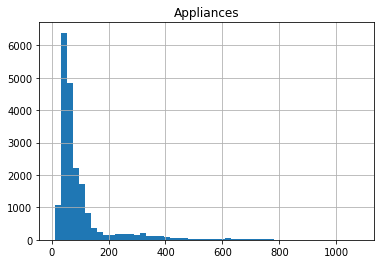

In [5]:
df.hist(column="Appliances", bins=50)

In [6]:
df.isnull().values.any()

False

In [7]:
df = df.sample(frac=1, random_state=41)

In [8]:
col_num = len(df.columns)
row_num = len(df.index)
print("Number of columns is: {} and number of rows is: {}".format(col_num, row_num))

Number of columns is: 28 and number of rows is: 19735


In [9]:
trainx = df.iloc[:int(0.8*row_num), 1:(col_num-2)]
trainy = df.iloc[:int(0.8*row_num), 0]

testx = df.iloc[int(0.8*row_num):, 1:(col_num-2)]
testy = df.iloc[int(0.8*row_num):, 0]

In [10]:
scaler = StandardScaler()
trainx_scaled = pd.DataFrame(scaler.fit_transform(trainx), columns = trainx.columns, index = trainx.index)
textx_scaled = pd.DataFrame(scaler.transform(testx), columns = testx.columns, index = testx.index)

In [24]:
import random
def create_rand_list(max_val, count):
    randomlist = random.sample(range(0, max_val + 1), count)
    return randomlist

[2, 1, 8, 9, 10, 3]

In [ ]:
def get_MICS_model(inp_size, drop_out, hidden_num = 4, hidden_size=32):
    inputs = keras.layers.Input(shape=(inp_size), name="input")
        
    h = keras.layers.Dense(hidden_size, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3))(inputs)
    h = keras.layers.Dropout(drop_out)(h)
    for hidden in range(hidden_num):
        h = keras.layers.Dense(hidden_size, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3))(h)
        h = keras.layers.Dropout(drop_out)(h) 

    outputs = keras.layers.Dense(1, activation="relu")(h)    
    return keras.Model(inputs=[inputs], outputs = outputs)

In [47]:
rand_list = create_rand_list(24, 12)

In [48]:
train_x_rand = trainx_scaled.iloc[:,rand_list]
test_x_rand = textx_scaled.iloc[:,rand_list]

In [49]:
inp_size = len(test_x_rand.columns)

In [52]:
min_losses = {12:[], 14:[], 16:[], 18:[], 20:[], 22:[], 24:[]}

In [67]:
min_losses3 = {10:[]}
for c in min_losses3.keys():
    i = 0
    while i<5:
        rand_list = create_rand_list(24, c)
        train_x_rand = trainx_scaled.iloc[:,rand_list]
        test_x_rand = textx_scaled.iloc[:,rand_list]
        inp_size = len(test_x_rand.columns)
        MICS_model = get_MICS_model(inp_size, drop_out = 0.25)
        callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50), 
                keras.callbacks.ReduceLROnPlateau("val_loss", factor = 0.8, patience=30,
                                                 verbose = 2, mode = "auto", 
                                                  min_lr = 1e-6)]
        MICS_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss=keras.losses.MeanSquaredError())
        history = MICS_model.fit(x = [train_x_rand], y = trainy.values,  
                                 validation_data = ([test_x_rand], testy.values),
                                 epochs=300, batch_size = 300, callbacks=callback)
        training_val_loss = history.history["val_loss"]
        best_row_index = np.argmin(training_val_loss)
        best_val_loss = training_val_loss[best_row_index]
        min_losses3[c].append(best_val_loss)
        i = i + 1

Epoch 1/300
53/53 [==============================] - 0s 5ms/step - loss: 12861.0801 - val_loss: 9071.1396
Epoch 2/300
53/53 [==============================] - 0s 3ms/step - loss: 10378.6143 - val_loss: 8761.9131
Epoch 3/300
53/53 [==============================] - 0s 3ms/step - loss: 10198.3516 - val_loss: 8605.9541
Epoch 4/300
53/53 [==============================] - 0s 2ms/step - loss: 10070.1631 - val_loss: 8691.7500
Epoch 5/300
53/53 [==============================] - 0s 2ms/step - loss: 9918.5449 - val_loss: 8615.9971
Epoch 6/300
53/53 [==============================] - 0s 2ms/step - loss: 9812.3535 - val_loss: 8873.6758
Epoch 7/300
53/53 [==============================] - 0s 2ms/step - loss: 9851.2334 - val_loss: 8575.6230
Epoch 8/300
53/53 [==============================] - 0s 3ms/step - loss: 9830.8213 - val_loss: 8567.0088
Epoch 9/300
53/53 [==============================] - 0s 2ms/step - loss: 9769.2314 - val_loss: 8597.9980
Epoch 10/300
53/53 [==============================]

In [61]:
min_losses

{12: [7689.59619140625,
  7481.36279296875,
  7247.634765625,
  7873.80126953125,
  7149.958984375],
 14: [7135.24658203125,
  6991.34423828125,
  7087.94091796875,
  7667.43408203125,
  7400.22607421875],
 16: [7182.0791015625,
  6900.39892578125,
  7286.2451171875,
  7464.94580078125,
  7165.7890625],
 18: [6945.58056640625,
  6785.36181640625,
  7037.0595703125,
  6850.4775390625,
  7082.39306640625],
 20: [6719.595703125,
  7220.4541015625,
  6916.8408203125,
  7228.6123046875,
  7138.6181640625],
 22: [6814.2939453125,
  7247.37939453125,
  6913.01220703125,
  7015.9736328125,
  6917.2880859375],
 24: [6928.3271484375,
  6742.07470703125,
  6775.55224609375,
  7043.486328125,
  6863.68115234375]}

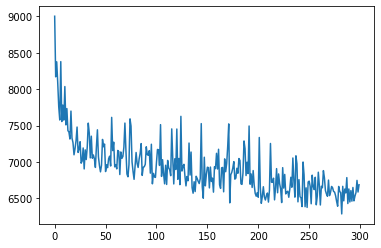

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history["val_loss"])

In [63]:
import copy
min_losses2 = copy.deepcopy(min_losses)
min_losses2

{12: [7689.59619140625,
  7481.36279296875,
  7247.634765625,
  7873.80126953125,
  7149.958984375],
 14: [7135.24658203125,
  6991.34423828125,
  7087.94091796875,
  7667.43408203125,
  7400.22607421875],
 16: [7182.0791015625,
  6900.39892578125,
  7286.2451171875,
  7464.94580078125,
  7165.7890625],
 18: [6945.58056640625,
  6785.36181640625,
  7037.0595703125,
  6850.4775390625,
  7082.39306640625],
 20: [6719.595703125,
  7220.4541015625,
  6916.8408203125,
  7228.6123046875,
  7138.6181640625],
 22: [6814.2939453125,
  7247.37939453125,
  6913.01220703125,
  7015.9736328125,
  6917.2880859375],
 24: [6928.3271484375,
  6742.07470703125,
  6775.55224609375,
  7043.486328125,
  6863.68115234375]}

In [64]:
avg_losses = {}
for count in min_losses2.keys():
    avg_losses[count] = sum(min_losses2[count])/len(min_losses2[count])
avg_losses

{12: 7488.47080078125,
 14: 7256.43837890625,
 16: 7199.8916015625,
 18: 6940.17451171875,
 20: 7044.82421875,
 22: 6981.589453125,
 24: 6870.62431640625}

In [71]:
sum(min_losses3[10])/5

7548.93408203125